### Hoek van Holland

Code of Capstone (bachelor thesis) Marit Verbeek, June 1st 2022.

In this second notebook, I create the results for our second location along the Ducht coast, Hoek van Holland. For more detailed information on the steps, I refer to the first main notebook.

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as scipy
from scipy import signal
import matplotlib
import matplotlib.pyplot as plt
rng = np.random.default_rng()
import cartopy.crs as ccrs
import cartopy
from scipy import signal
import matplotlib.pyplot as plt
rng = np.random.default_rng()

#### Selecting model location

First, we need to select the location in the model closest to the tide gauge station coordinates.

In [2]:
# We define a function for selecting the location:
def location(ds, lat, lon):
    """Give location"""
    abslat = np.abs(ds.latitude-lat)
    abslon = np.abs(ds.longitude-lon)
    c = np.maximum(abslon, abslat)
    ([yloc],[xloc]) = np.where(c == np.min(c))
    return xloc, yloc

In [3]:
#Ccombining model data into single DataArray:
times   = pd.date_range(start='1950-01-01', end='2101-01-01', freq='M')# np.arange(1950,2101,1/12)
srcs    = ['EC-Earth3P', 'EC-Earth3P-HR']
exps    = ['control', 'hist+future']
members = [f'r{i}i1p2f1' for i in range(1,4)]
data    = np.empty((len(times), len(srcs), len(exps), len(members)))
data[:,:,:,:] = np.nan
da_new = xr.DataArray(dims=['time', 'src', 'exp', 'member'],
                      coords={'time':times, 'src':srcs, 'exp':exps, 'member':members},
                      data=data,
                     )

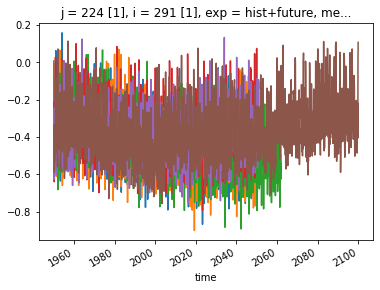

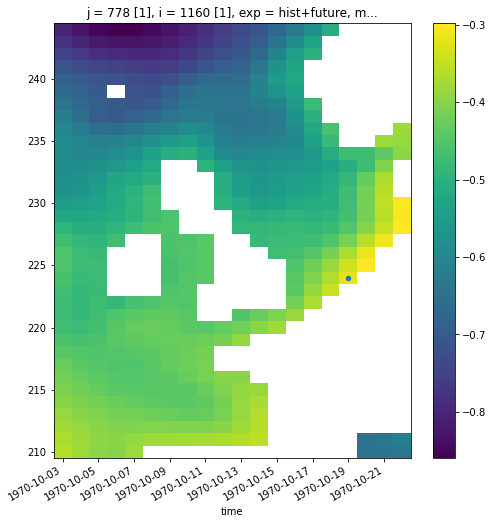

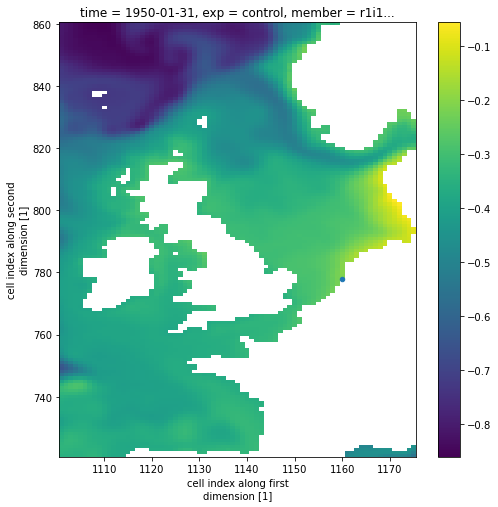

In [4]:
for s, res in enumerate(['SR','HR']):
    ds = xr.open_dataarray(f'../data/zos_NorthSea_{res}.nc')
    ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))
    
    # Select location:
    lat_H, lon_H = 52.2, 4.20   # coordinates Hoek v. Holland tide gauge station
    xloc, yloc = location(ds=ds, lat=lat_H, lon=lon_H)
    dsl = ds.isel({'i':xloc,'j':yloc})
    
    for e, exp in enumerate(exps):
        for m, mem in enumerate(members):
            ds_ = dsl.sel({'exp':exp, 'member':mem})
            te = len(ds_.time)
            ds_.plot()
            da_new[:te, s, e,m] = ds_.values
            
    ds.isel({'exp':0, 'member':0, 'time':0}).plot(figsize=(8,8)) # Here we plot the time-series
    plt.scatter(ds.i.isel({'i':xloc}).values,
                    ds.j.isel({'j':yloc}).values, s=20) # Here we have a look at the location in the map
    
# We now create a new file of the zos data in Hoek van Holland:
#da_new.to_netcdf('../data/zos_hoek1.nc')

#### Reading tide gauge data

In [5]:
# Then we open the tide gauge data and turn it into a useful format:
dtg = pd.read_csv('../data/tidegauge_psmsl/22.rlrdata.txt', #22 is Hoek van Holland
                 sep=';', usecols=[1], 
                 names=['level'])  

In [6]:
# Now we define dates and months for the period used:
dates = pd.date_range(start='1864-01-01', end='2021-01-01', 
                      freq='M') 

# And we add dates to the data so we can create nice time series:
dtg['time'] = dates 
dtg = dtg.set_index('time')

### The time series

##### Model zos

Text(0.84, 0.98, 'end-century')

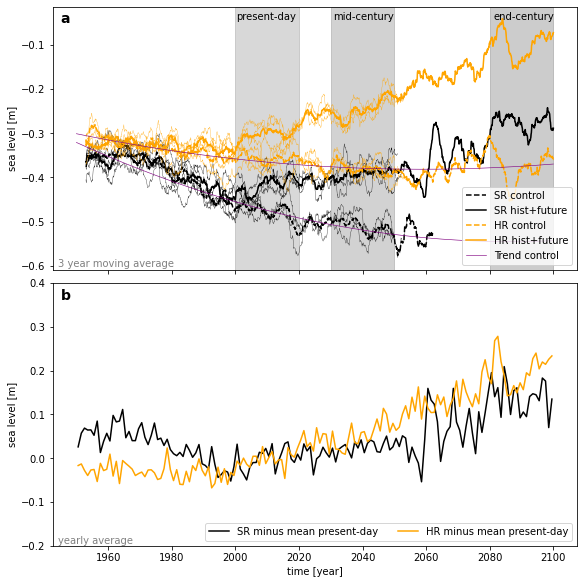

In [7]:
f, ax = plt.subplots(2,1, figsize=(8,8), sharex=True, constrained_layout=True)
f.align_ylabels()

df= xr.open_dataarray('../data/zos_hoek1.nc')

# In the first figure we plot all model data; SR and HR control and hist+future over the whole time series for the three members:
for i, Src in enumerate(df.src.values): # Src is SR and HR    
    for j, Exp in enumerate(df.exp.values): # Exp are the two simulations      
        timevalues = df.time.dt.year + df.time.dt.month/12 # We want the means per year
        # Now, we create the actual plot for this using a three year rolling average to make it clearer:
        # First plot the time series for the average of all members:
        ax[0].plot(timevalues, df.mean('member').sel({'exp':Exp, 'src':Src}).rolling(time=36).mean(), 
                   label=f'{["SR","HR"][i]} {Exp}', color=['black','orange'][i], ls=['--','-'][j])
       
        # Then all the ensemble members seperately, too:
        for mem in df.member.values:
            ax[0].plot(timevalues, df.sel({'member':mem, 'exp':Exp, 'src':Src}).rolling(time=36).mean(),
                       color=['black','orange'][i], lw=.3)
            
# Then, we also want to show the trends in the control run:
dc =df.mean('member').sel(exp='control').sel(src='EC-Earth3P').groupby(df.time.dt.year).mean()
# Then we do the second degree fitting for the control run:
fit1 = dc.polyfit(dim='year', deg=2).polyfit_coefficients 
# So then below is the curve for the trend in the control run:
ts1 = dc.year**2*fit1[0] + dc.year*fit1[1]+fit1[2] 
ax[0].plot(ts1.year, ts1, label = f'Trend control', color='purple', lw=0.6)

# Then we do exactly the same for HR:
dch=df.mean('member').sel(exp='control').sel(src='EC-Earth3P-HR').groupby(df.time.dt.year).mean()
fit2 = dch.polyfit(dim='year', deg=2).polyfit_coefficients 
ts2 = dch.year**2*fit2[0] + dch.year*fit2[1]+fit2[2] 
ax[0].plot(ts2.year, ts2, color='purple', lw=0.6)


# In b), ([ax]1) we will plot the hist+future for the mean of the members, minus the mean of present-day:

# First, we select the mean of the members and the correct simulation:
hf = df.sel(exp='hist+future').mean('member')

# Then we create the present-day mean to subtract that from the runs, once for SR and once for HR:
presentday = hf.sel(time=slice('2000-01-31', '2020-12-31'))

#SR:
psds = presentday.sel(src='EC-Earth3P')
hists = hf.sel(src='EC-Earth3P') - psds.mean() 
ax[1].plot(timevalues.groupby(df.time.dt.year).mean(), hists.groupby(hists.time.dt.year).mean(), 
            label=f'SR minus mean present-day', color='black')

#HR:
psdh = presentday.sel(src='EC-Earth3P-HR')
histh = hf.sel(src='EC-Earth3P-HR') - psdh.mean()
ax[1].plot(timevalues.groupby(df.time.dt.year).mean(), histh.groupby(histh.time.dt.year).mean(), 
            label=f'HR minus mean present-day', color='orange')


# Then we set the layout for the figures:
ax[0].set_ylabel('sea level [m]')
ax[0].legend(ncol=1, loc=4)
ax[0].text(.01,.01, '3 year moving average', color='grey', transform=ax[0].transAxes)
ax[0].text(.015,.98, 'a', transform=ax[0].transAxes, va='top', ha='left', weight='bold', fontsize=14, color='black')  
ax[1].set_ylabel('sea level [m]')
ax[1].set_ylim((-0.2, 0.4))
ax[1].set_xlabel('time [year]')
ax[1].text(.01,.01, 'yearly average', color='grey', transform=ax[1].transAxes)
ax[1].legend(ncol=2, loc=4)
ax[1].text(.015,.98, 'b', transform=ax[1].transAxes, va='top', ha='left', weight='bold', fontsize=14, color='black')

# Here we create three grey boxes to show the different time spans we will refer to further on:
ax[0].axvspan(2000,2020, color='grey', alpha=.3) 
ax[0].text(.35,.98, 'present-day', transform=ax[0].transAxes, va='top', fontsize=10, color='black')
ax[0].axvspan(2030,2050, color='grey', alpha=.35)
ax[0].text(.535,.98, 'mid-century', transform=ax[0].transAxes, va='top', fontsize=10, color='black')
ax[0].axvspan(2080,2100, color='grey', alpha=.4)
ax[0].text(.84,.98, 'end-century', transform=ax[0].transAxes, va='top', fontsize=10, color='black')

# Lastly, we save the figure:
#f.savefig('../results/modelserieshoek.jpg', dpi=300, bbox_inches='tight')

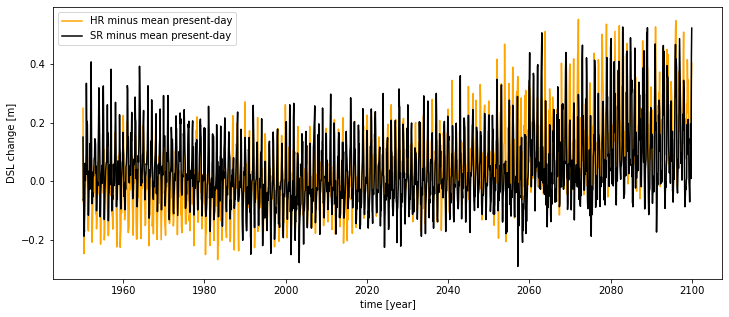

In [8]:
fig = plt.figure(figsize=(12,5))

# We use the 'histh' and 'hists' from the previous plot, 
# which are the member-mean historic and future simulations, minus the mean of 2000-2020.
# Then, we simply plot this as monthly means

plt.plot(df.time, histh, 
            label=f'HR minus mean present-day', color='orange')
plt.plot(df.time, hists, 
            label=f'SR minus mean present-day', color='black')

plt.ylabel('DSL change [m]')
plt.xlabel('time [year]')
plt.legend()
#fig.savefig('../results/extremeshoek.jpg', dpi=300, bbox_inches='tight')

##### Tide gauge observations

Text(0, 0.5, 'sea level above NAP [m]')

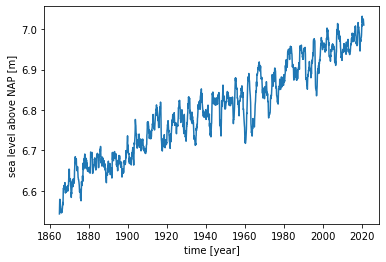

In [9]:
# I will turn the montlhy means into yearly averages and convert the level from milimeters to meters and plot the result:
plt.plot(dtg.to_xarray().time.dt.year + dtg.to_xarray().time.dt.month/12, dtg.to_xarray().level.rolling(time=12).mean().values/1000) 

# Then setting the figure layout:
plt.xlabel('time [year]')
plt.ylabel('sea level above NAP [m]')

# And saving the result:
#plt.savefig('../results/tghoek.jpg', dpi=300, bbox_inches='tight')

### Spectral analysis

In [10]:
# Since the tide gauge data is in unix time until nanoseconds, 
#  we need to convert this to do the spectral analysis in monthly means:
tg = dtg.squeeze().to_xarray()
tg = tg/1000 # Here we turn the millimeter level into meters
dt64 = tg.time.values
unix_epoch = np.datetime64(0, 's')
one_second = np.timedelta64(1, 's')
one_nsecond = np.timedelta64(1, 'ns')
unix_secs = (dt64 - unix_epoch)/one_second
unix_nsecs = (tg.time.values - unix_epoch)/one_nsecond

Text(0, 0.5, 'sea level above NAP [m]')

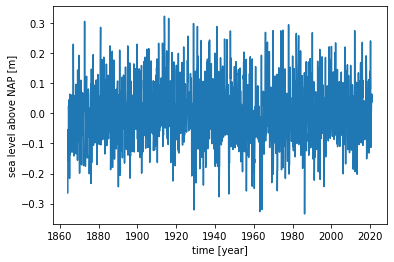

In [11]:
# Now, we want to de-trend the timeseries for a clean spectral analysis:
fit = tg.polyfit(dim='time', deg=1).polyfit_coefficients

# So then the time series of the fit will be:
ts = unix_nsecs*fit[0].values + fit[1].values
# Which we subtract from the original series to get the desired de-trending:
dgdt = tg-ts
# So finally, we plot the following:
plt.plot(tg.time, dgdt)

# Then setting the figure layout:
plt.xlabel('time [year]')
plt.ylabel('sea level above NAP [m]')

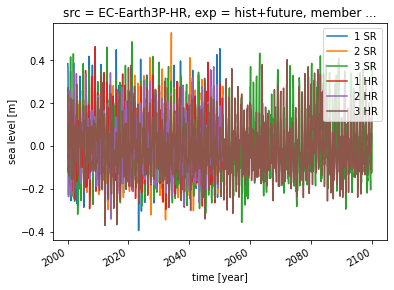

In [12]:
# Next, we de-trend the model time series:

dr_lst = []
for i, Src in enumerate(df.src.values): # Src is SR and HR

    for j, mem in enumerate(df.member.values): # mem are the ensemble members:
        dt = df.sel({'src':Src}).sel({'member':mem}).sel(time=slice('2000-01-31', '2100-12-31')) 
        dc = dt.sel(exp='control')
        unix_nsecs = (dc.time.values - unix_epoch)/one_nsecond
        
        # Now, we do the first fitting for the control run:
        fit1 = dc.polyfit(dim='time', deg=1).polyfit_coefficients
        
        # This gives the following trend we need to subtract from the hist+future run:
        ts = unix_nsecs*fit1[0].values + fit1[1].values
       
        dh = dt.sel(exp='hist+future')
        dhf = dh-ts
        
        # Then, we need to take out the trend that is in that time series for a good spectral analysis:
        fit3 = dhf.polyfit(dim='time', deg=1).polyfit_coefficients
        ts3 = unix_nsecs*fit3[0].values + fit3[1].values
        
        # So we will use the following time series for the spectral analysis:
        dr = dhf-ts3   
        dr_lst.append(dr)
        dr.plot(label=f'{["1","2", "3"][j]} {["SR", "HR"][i]}') 
        
plt.xlabel('time [year]')
plt.ylabel('sea level [m]')
plt.legend()

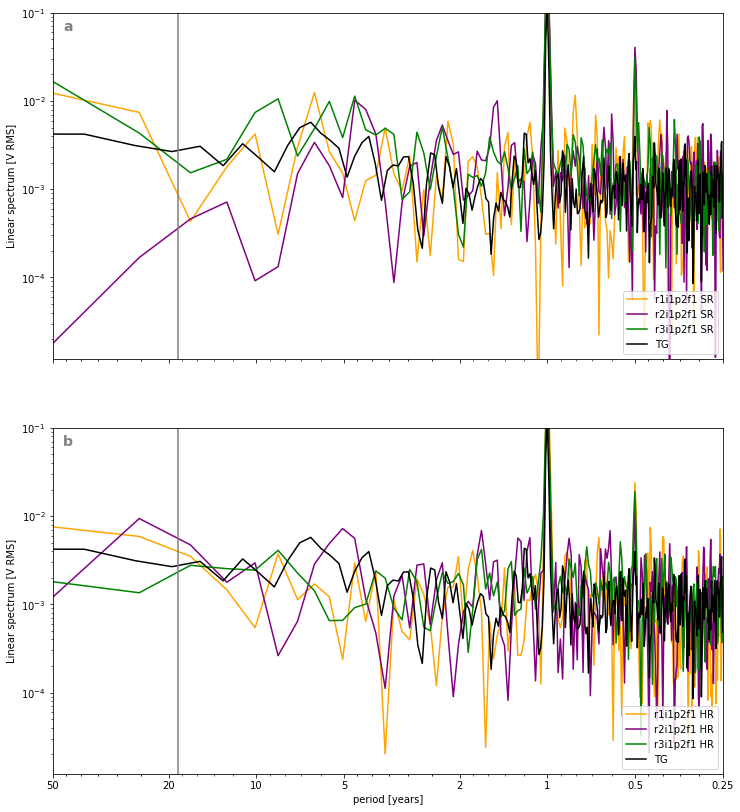

In [13]:
# Now, we can apply the actual Welch method to the de-trended time series we created. 
# We will create two panels; one for the SR ensemble members, and one for the HR:
f, ax = plt.subplots(2,1, figsize=(12,14), sharex=True)
f.align_ylabels()

# First, we create the ticks for the x-axis, for the variabilities we want to plot:
xticks = [50,20,10,5,2,1,.5,.25]
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=[1/x for x in [45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]],numticks=10)

# Now, we can do the actual Welch analysis:
s1, s1spec = signal.welch(dr_lst[0].sel()[:-606], fs=12, nperseg=606, detrend = False, return_onesided=True)
ax[0].plot(s1, s1spec, label=f'r1i1p2f1 SR', color='orange')
s2, s2spec = signal.welch(dr_lst[1].sel()[:-606], fs=12, nperseg=606, detrend = False, return_onesided=True)
ax[0].plot(s2, s2spec, label=f'r2i1p2f1 SR', color='purple')
s3, s3spec = signal.welch(dr_lst[2].sel()[:-2], fs=12, nperseg=606, detrend = False, return_onesided=True)
ax[0].plot(s3, s3spec, label=f'r3i1p2f1 SR', color='green')
h1, h1spec = signal.welch(dr_lst[3].sel()[:-606], fs=12, nperseg=606, detrend = False, return_onesided=True)
ax[1].plot(h1, h1spec, label=f'r1i1p2f1 HR', color='orange')
h2, h2spec = signal.welch(dr_lst[4].sel()[:-606], fs=12, nperseg=606, detrend = False, return_onesided=True)
ax[1].plot(h2, h2spec, label=f'r2i1p2f1 HR', color='purple')
h3, h3spec = signal.welch(dr_lst[5].sel()[:-2], fs=12, nperseg=606, detrend = False, return_onesided=True)
ax[1].plot(h3, h3spec, label=f'r3i1p2f1 HR', color='green')
ax[0].text(.015,.98, 'a', transform=ax[0].transAxes, va='top', ha='left', weight='bold', fontsize=14, color='grey')
ax[1].text(.015,.98, 'b', transform=ax[1].transAxes, va='top', ha='left', weight='bold', fontsize=14, color='grey')

# The following applies to both axes, so we will loop over them:
for i, x in enumerate([0, 1]):

    tgs, Pxx_spec = signal.welch(dgdt, fs=12, nperseg=2*468,  detrend = False, return_onesided=True)
    ax[i].plot(tgs, Pxx_spec, label='TG', color='black')    
    ax[i].set_xscale('log', base=10)
    ax[i].set_yscale('log', base=10)
    ax[i].set_xlim((1/50,1/24))
    ax[i].set_ylim((1.2e-5,1e-1))
    
    ax[i].set_ylabel('Linear spectrum [V RMS]')
    ax[i].axvline(1/18.6, c='C7')
    ax[i].xaxis.set_minor_locator(locmin)
    ax[i].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax[i].set_xticks([1/x for x in xticks])
    ax[i].set_xticklabels(xticks)
    ax[1].set_xlabel('period [years]')
    ax[0].legend(ncol=1, loc=4)
    ax[1].legend(ncol=1, loc=4)
    

#plt.savefig('../results/welchdelf.jpg', dpi=300, bbox_inches='tight')

In [14]:
def power_mean(power, freq, period1, period2):
    """ docstring """
    assert period1>period2, f'period1 needs to be larger than period2'
    A = (power, freq)                              # (spectral power: [arbitrary units], frequencies: [1/years])
    f = (A[1]>1/period1)*(A[1]<=1/period2)   # selecting periods between period1 and period2
    w = np.log(A[1][1:])*f[1:]                  # creating weights
    mu_ = np.average(A[0][1:], weights=w)     # calculating the weighted mean
    return mu_

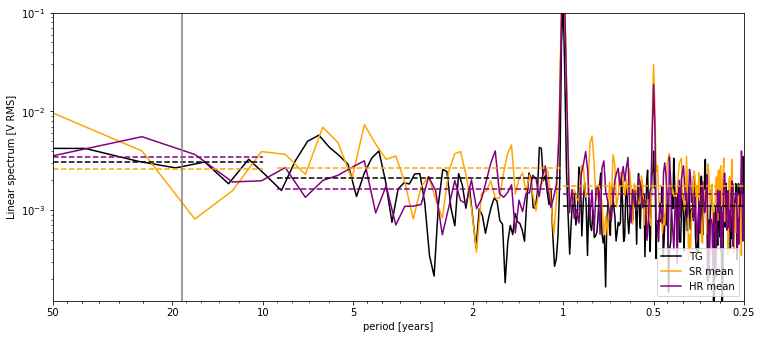

In [15]:
# Now, we will create the means of the spectra of the ensemble members above.
xticks = [50,20,10,5,2,1,.5,.25]
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=[1/x for x in [45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]],numticks=10)

fig = plt.figure(figsize=(12,5))
ax = fig.add_axes([0.1,0.1,.8,.8])
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.set_xlim((1/50,1/24))
ax.set_ylim((1.2e-4,1e-1))

tgs, Pxx_spec = signal.welch(dgdt, fs=12, nperseg=2*468,  detrend = False, return_onesided=True)
plt.plot(tgs, Pxx_spec, label='TG', color='black')
s = (s1spec+s2spec+s3spec)/3
plt.plot(s1, s, label= 'SR mean', color='orange')
h = (h1spec+h2spec+h3spec)/3
plt.plot(s1, h, label = 'HR mean', color='purple')

period1, period2 = 50, 10
mu_tg = power_mean(Pxx_spec, tgs, period1=50, period2=10)
plt.plot([1/period1,1/period2], 2*[mu_tg], color='black', ls=('--'))
mu_s = power_mean(s, s1, period1=50, period2=10)
plt.plot([1/period1,1/period2], 2*[mu_s], color='orange', ls=('--'))
mu_h = power_mean(h, s1, period1=50, period2=10)
plt.plot([1/period1,1/period2], 2*[mu_h], color='purple', ls=('--'))

p1, p2 = 9, 1
mu_tga = power_mean(Pxx_spec, tgs, period1=9, period2=1)
plt.plot([1/p1,1/p2], 2*[mu_tga], color='black', ls=('--'))
mu_sa = power_mean(s, s1, period1=5, period2=1)
plt.plot([1/p1,1/p2], 2*[mu_sa], color='orange', ls=('--'))
mu_ha = power_mean(h, s1, period1=5, period2=1)
plt.plot([1/p1,1/p2], 2*[mu_ha], color='purple', ls=('--'))

pd1, pd2 = 1, 0.25
mu_tga = power_mean(Pxx_spec, tgs, period1=1, period2=.25)
plt.plot([1/pd1,1/pd2], 2*[mu_tga], color='black', ls=('--'))
mu_sa = power_mean(s, s1, period1=1, period2=.25)
plt.plot([1/pd1,1/pd2], 2*[mu_sa], color='orange', ls=('--'))
mu_ha = power_mean(h, s1, period1=1, period2=.25)
plt.plot([1/pd1,1/pd2], 2*[mu_ha], color='purple', ls=('--'))

plt.ylabel('Linear spectrum [V RMS]')
plt.axvline(1/18.6, c='C7')
plt.legend(loc=4)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_xticks([1/x for x in xticks])
ax.set_xticklabels(xticks)
ax.set_xlabel('period [years]')
fig.align_ylabels()

#plt.savefig('../results/welchmeanshoek.jpg', dpi=300, bbox_inches='tight')